# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Exploring Fake News

In [3]:
fake_df = pd.read_csv('.//Dataset/Fake.csv')
fake_df.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [4]:
#Counting by Subjects 
for key, count in fake_df['subject'].value_counts().items():
    print(f"{key}:\t{count}")

# Getting Total Rows
total_rows = len(fake_df)
print("Total Rows:", total_rows)

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Rows: 23481


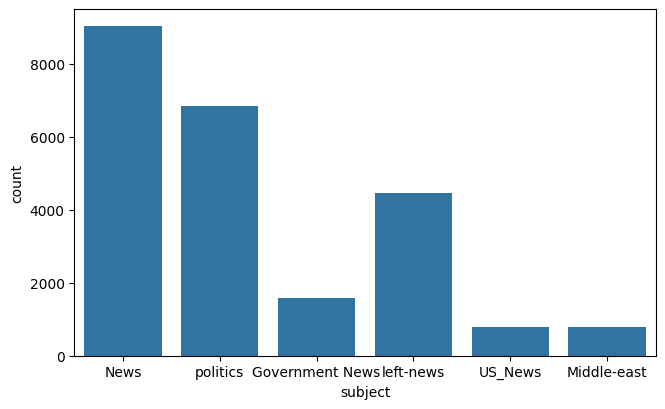

In [5]:
plt.figure(figsize=(7.5,4.5))
sns.countplot(x="subject", data=fake_df)
plt.savefig('.//Figures/FakeNewCategories.pdf')
plt.show()

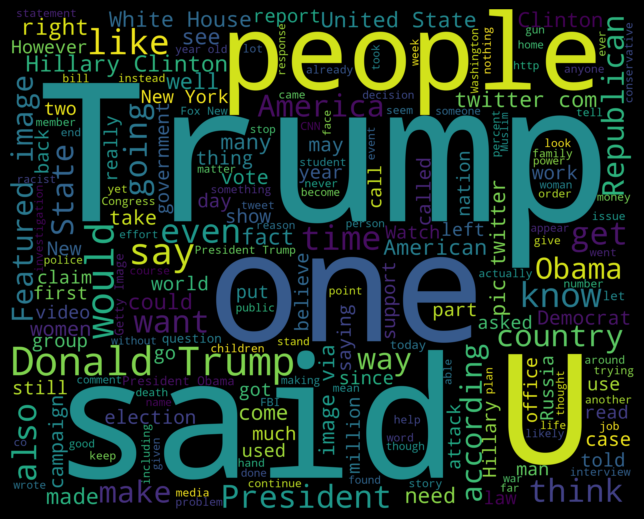

In [6]:
#Word Cloud
text = ''
for news in fake_df.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 2500,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (7, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
wordcloud.to_file(".//Figures/fakenews_wordcloud.pdf")
plt.show()
del text

# Exploring Real news

In [7]:
real_df = pd.read_csv('.//Dataset/True.csv')
real_df.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


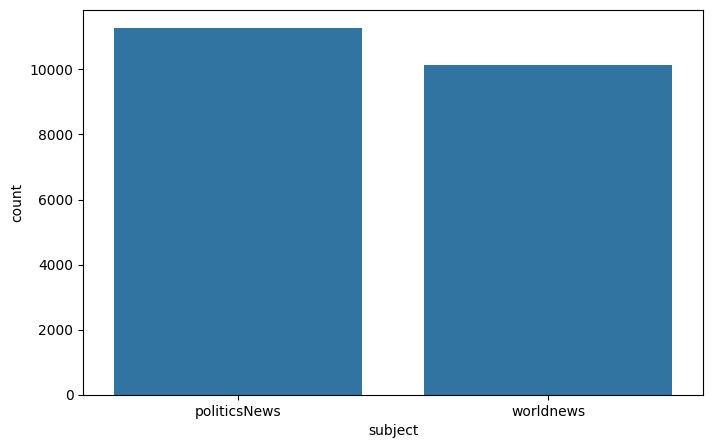

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=real_df)
plt.savefig('.//Figures/RealNewsCategories.pdf')
plt.show()

In [9]:
real_df.shape

(21417, 4)

# Difference in Text

Real news typically includes a publication source, unlike fake news. Analyzing the data reveals that:

The majority of the text includes Reuters attribution, like "WASHINGTON (Reuters)".
Some text consists of tweets from Twitter.
A small portion of the text lacks any publication information.

# Data Cleaning

When eliminating Reuters or Twitter tweet details from the text:

The text is split only once at " - ", consistently occurring after mentioning the source of publication. This division provides the publication segment and the text segment.
If no text segment is retrieved, it indicates that publication details were not provided for that record.
Twitter tweets consistently originate from the same source, a lengthy text with a maximum of 259 characters.

In [10]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real_df.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [11]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real_df.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [12]:
real_df.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [13]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real_df.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [14]:
#Replace existing text column with new text
#add seperate column for publication info
real_df["publisher"] = publisher
real_df["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [15]:
real_df.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [16]:
 #checking for rows with empty text like row:8970
[index for index,text in enumerate(real_df.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [17]:
#dropping this record
real_df.drop(8970, axis=0,inplace=True)

In [18]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake_df.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_df.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [19]:
fake_df.drop(empty_fake_index, axis=0,inplace=True)

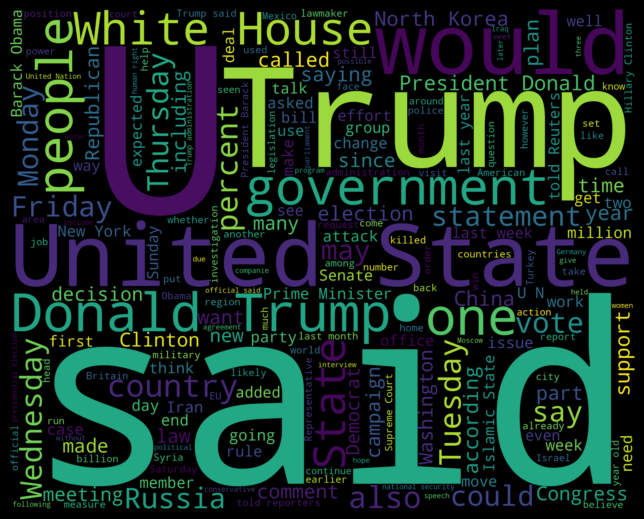

In [20]:
#WordCloud For Real News
text = ''
for news in real_df.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 2500,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (7, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
wordcloud.to_file(".//Figures/realnews_wordcloud.pdf")
plt.show()
del text

# Preprocessing Text

In [21]:
# Adding class Information
real_df["class"] = 1
fake_df["class"] = 0

In [22]:
#Combining Title and Text
real_df["text"] = real_df["title"] + " " + real_df["text"]
fake_df["text"] = fake_df["title"] + " " + fake_df["text"]

In [23]:
# Subject is diffrent for real and fake thus dropping it
# And dropping Date, title and Publication Info of real
real_df = real_df.drop(["subject", "date","title",  "publisher"], axis=1)
fake_df = fake_df.drop(["subject", "date", "title"], axis=1)

In [24]:
real_df.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [25]:
fake_df.head()

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [26]:
#Combining both into new dataframe
df = pd.concat([real_df, fake_df], ignore_index=True)
del real_df, fake_df

In [27]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
y = df["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del df

In [29]:
X[:1]

[['budget',
  'fight',
  'looms',
  'republicans',
  'flip',
  'fiscal',
  'script',
  'head',
  'conservative',
  'republican',
  'faction',
  'congress',
  'voted',
  'month',
  'huge',
  'expansion',
  'national',
  'debt',
  'pay',
  'tax',
  'cuts',
  'called',
  'fiscal',
  'conservative',
  'sunday',
  'urged',
  'budget',
  'restraint',
  '2018',
  'keeping',
  'sharp',
  'pivot',
  'way',
  'among',
  'republicans',
  'representative',
  'mark',
  'meadows',
  'speaking',
  'cbs',
  'face',
  'nation',
  'drew',
  'hard',
  'line',
  'federal',
  'spending',
  'lawmakers',
  'bracing',
  'battle',
  'january',
  'return',
  'holidays',
  'wednesday',
  'lawmakers',
  'begin',
  'trying',
  'pass',
  'federal',
  'budget',
  'fight',
  'likely',
  'linked',
  'issues',
  'immigration',
  'policy',
  'even',
  'november',
  'congressional',
  'election',
  'campaigns',
  'approach',
  'republicans',
  'seek',
  'keep',
  'control',
  'congress',
  'president',
  'donald',
  'tru

In [30]:
y[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [31]:
y[-5:]

array([0, 0, 0, 0, 0], dtype=int64)

In [32]:
import gensim

# Vectorization -- Word2Vec

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [33]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [34]:
#vocab size
vocab_size = len(w2v_model.wv.key_to_index)

#We have now represented each of 122238 words by a 100dim vector.

In [35]:
#see a sample vector for random word, lets say House
word_vector = w2v_model.wv["house"]

In [36]:
w2v_model.wv.most_similar("trump")

[('elect', 0.632427453994751),
 ('cruz', 0.5717438459396362),
 ('conway', 0.5055943131446838),
 ('obama', 0.4984559118747711),
 ('actually', 0.4965607225894928),
 ('ridiculous', 0.49550050497055054),
 ('outright', 0.48084354400634766),
 ('rubio', 0.47674742341041565),
 ('hillary', 0.4749429523944855),
 ('president', 0.4725455343723297)]

In [37]:
w2v_model.wv.most_similar("america")

[('nation', 0.736617922782898),
 ('country', 0.6808405518531799),
 ('american', 0.5624536275863647),
 ('us', 0.5521495342254639),
 ('world', 0.547528862953186),
 ('americans', 0.5299918055534363),
 ('africa', 0.5176815986633301),
 ('europe', 0.5131661891937256),
 ('truly', 0.5101478099822998),
 ('alphabets', 0.5038517117500305)]

In [38]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7266280651092529),
 ('investigators', 0.6182554960250854),
 ('investigation', 0.6053515672683716),
 ('mueller', 0.5999268889427185),
 ('cia', 0.5972725749015808),
 ('doj', 0.5954616069793701),
 ('investigations', 0.5639091730117798),
 ('nunes', 0.5468743443489075),
 ('inquiry', 0.5455084443092346),
 ('probe', 0.522774875164032)]

In [39]:
w2v_model.wv.most_similar("google")

[('alphabet', 0.7591074109077454),
 ('fb', 0.7544894814491272),
 ('googl', 0.7056713700294495),
 ('apple', 0.6942959427833557),
 ('microsoft', 0.6936187744140625),
 ('facebook', 0.6676471829414368),
 ('app', 0.6493220329284668),
 ('algorithm', 0.6468272805213928),
 ('newsfeed', 0.6397104859352112),
 ('reddit', 0.6395169496536255)]

In [40]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('cruz', 0.5288440585136414),
 ('elect', 0.5088966488838196),
 ('bush', 0.5045168995857239),
 ('incoming', 0.4974794387817383),
 ('hillary', 0.49389398097991943),
 ('1140', 0.47275853157043457),
 ('americas_dad', 0.4616754651069641),
 ('course', 0.45357999205589294),
 ('crooked', 0.4512917101383209),
 ('actually', 0.4456193149089813)]

These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors.

Keras has implementation called "Embedding Layer" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.

We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [41]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [42]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[389, 395, 10493, 54, 5505, 1285, 4840, 315, 205, 16]

In [43]:
#Lets check few word to numerical reprsentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break   

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
also -> 9
obama -> 10


**Notice it starts with 1**

We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input

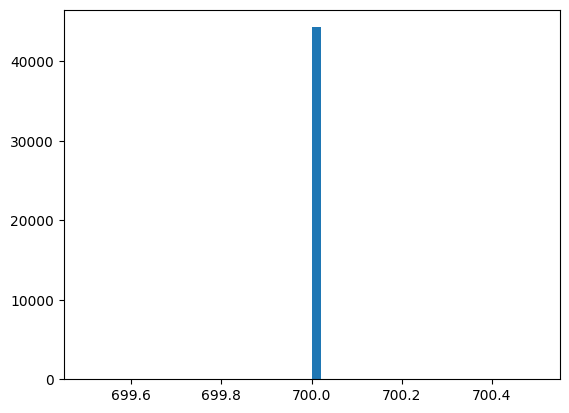

In [64]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=50)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :)

In [45]:
len(y)

44267

In [46]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
## Out of 44k news, 43k have less than 700 words

43352

In [47]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [48]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [49]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [50]:
vocab_size 

122239

In [51]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, tokenizer_word_index):
    vocab_size = len(tokenizer_word_index) + 1  # Total vocabulary size plus 0 for unknown words
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))  # Define weight matrix dimensions with all 0
    
    for word, i in tokenizer_word_index.items():
        if word in model.wv:
            weight_matrix[i] = model.wv[word]  # Store vectors using the Tokenizer's integer mapping
        else:
            print(f"Word '{word}' not found in Word2Vec model vocabulary.")
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [52]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [53]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12223900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12341277 (47.08 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 12223900 (46.63 MB)
_________________________________________________________________


In [55]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [56]:
model.fit(X_train, y_train, validation_split=0.3, epochs=7)

Epoch 1/7


727/727 [==============================] - 429s 586ms/step - loss: 0.1322 - acc: 0.9534 - val_loss: 0.1156 - val_acc: 0.9589
Epoch 2/7
727/727 [==============================] - 409s 563ms/step - loss: 0.0727 - acc: 0.9748 - val_loss: 0.0628 - val_acc: 0.9777
Epoch 3/7
727/727 [==============================] - 409s 563ms/step - loss: 0.0453 - acc: 0.9842 - val_loss: 0.0463 - val_acc: 0.9835
Epoch 4/7
727/727 [==============================] - 415s 570ms/step - loss: 0.0343 - acc: 0.9888 - val_loss: 0.0514 - val_acc: 0.9826
Epoch 5/7
727/727 [==============================] - 411s 566ms/step - loss: 0.0256 - acc: 0.9909 - val_loss: 0.0403 - val_acc: 0.9864
Epoch 6/7
727/727 [==============================] - 411s 565ms/step - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0334 - val_acc: 0.9903
Epoch 7/7
727/727 [==============================] - 411s 565ms/step - loss: 0.0151 - acc: 0.9953 - val_loss: 0.0356 - val_acc: 0.9894


In [57]:
from keras.models import load_model
# Save the trained model
model.save('trained_model.h5')

# Load the saved model
loaded_model = load_model('trained_model.h5')

In [58]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

346/346 [==============================] - 68s 195ms/step


In [59]:
accuracy_score(y_test, y_pred)

0.9905123339658444

In [60]:
print(classification_report(y_test, y_pred))
# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a pandas DataFrame
df_report = pd.DataFrame(report).transpose()

# Convert the DataFrame to LaTeX table format
latex_table = df_report.to_latex()

# Print or save the LaTeX table
print(latex_table)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5766
           1       0.99      0.99      0.99      5301

    accuracy                           0.99     11067
   macro avg       0.99      0.99      0.99     11067
weighted avg       0.99      0.99      0.99     11067

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.993204 & 0.988554 & 0.990874 & 5766.000000 \\
1 & 0.987613 & 0.992643 & 0.990121 & 5301.000000 \\
accuracy & 0.990512 & 0.990512 & 0.990512 & 0.990512 \\
macro avg & 0.990409 & 0.990598 & 0.990497 & 11067.000000 \\
weighted avg & 0.990526 & 0.990512 & 0.990513 & 11067.000000 \\
\bottomrule
\end{tabular}



In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[5700,   66],
       [  39, 5262]], dtype=int64)

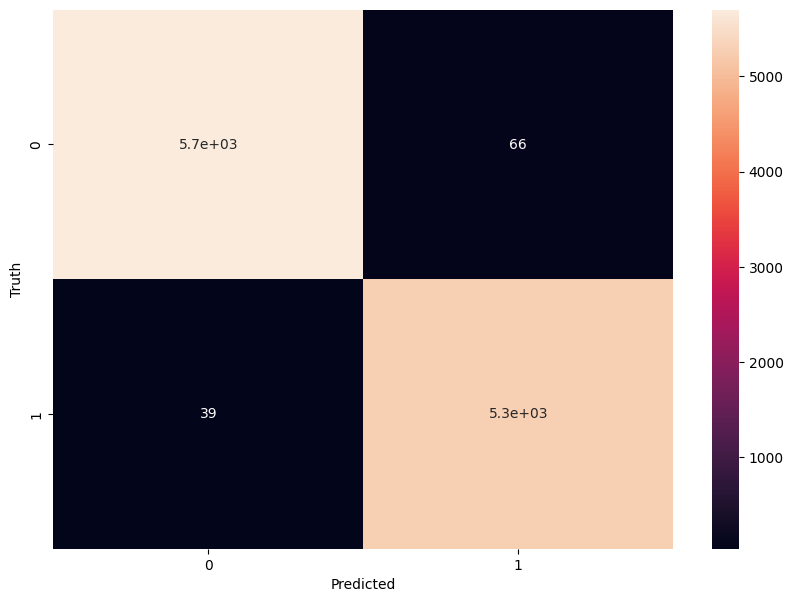

In [62]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('.//Figures/confusion_matrix.pdf', format='pdf')
plt.show()